In [27]:
import collections
import random
import numpy as np

class ReplyBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        transition = random.sample(self.buffer, batch_size)
        # 将batch_size组state、action、reward提取出来
        state, action, reward, next_state, done = zip(*transition)
        return np.array(state), action, reward, np.array(next_state), done
    def size(self):
        return len(self.buffer)

In [28]:
import torch
import torch.nn.functional as F
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)

        self.fc2_a = torch.nn.Linear(hidden_dim, action_dim)

        self.fc2_s = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        A = self.fc2_a(x)
        V = self.fc2_s(x)
        Q = V + A - A.mean(1).view(-1, 1)
        return Q

In [29]:
class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = Qnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
                -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


In [30]:
import gym
import rl_utils
lr = 1e-2
num_episodes = 300
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作


def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action /
                              (action_dim - 1)) * (action_upbound -
                                                   action_lowbound)

d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [31]:
from tqdm import tqdm
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(
                        state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env,
                                                   agent.action_dim)
                    next_state, reward, done, _ = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Iteration 9: 100%|██████████| 30/30 [00:06<00:00,  4.60it/s, episode=300, return=-188.101]


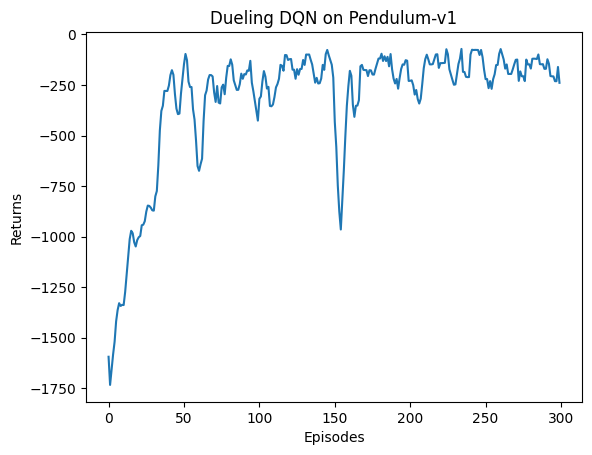

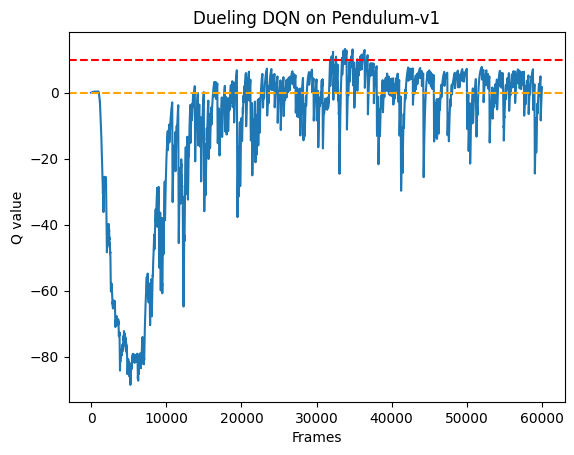

In [32]:
import matplotlib.pyplot as plt
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

In [33]:
import cv2
from matplotlib import animation 

def display_frames_as_gif(frames):
    
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
   
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=1)
    anim.save('./dqn_dueling_result.gif', writer='ffmpeg', fps=30)
    
def run_game(env):
    frames = []
    s = env.reset()
    rewards = 0
    for i_episode in range(1000):
        frames.append(env.render(mode='rgb_array'))
        # time.sleep(0.1)
        action = agent.take_action(s)
        continue_action = dis_to_con(action, env, action_dim)
        s_, r, done, info = env.step([continue_action])   
        s = s_
        rewards += r
        if done:  
            break
    
    display_frames_as_gif(frames)
    
    # env.close()
    return rewards


d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


-123.83234452656234


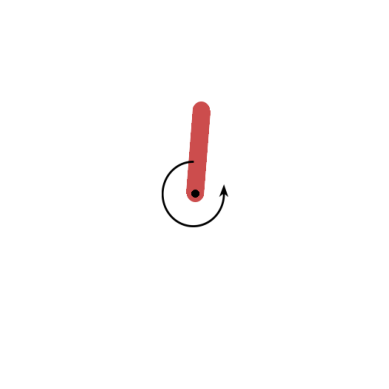

In [34]:
env.reset()
rewards = run_game(env)
print(rewards)